In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Temperature
T = 278
# Boltzmann constant
kB = 8.617332e-5
kT = kB * T

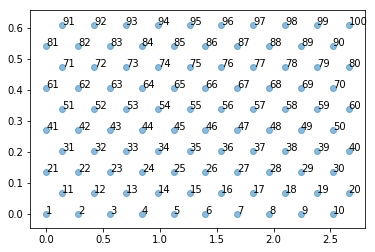

In [4]:
# N must be even and this will make a lattice with N points in x and N points in y directions

N = 10
d = 0.28

# set up square mesh

nx, ny = (N, N)
x = np.linspace(0, N-1, nx)*d
y = np.linspace(0, N-1, ny)*d
xv, yv = np.meshgrid(x, y)
xv_array = np.asarray(xv).reshape(-1)
yv_array = np.asarray(yv).reshape(-1)

# scaling for hexagonal points (in y)
y_scale = np.sqrt(3)/2*d
yv_hex = yv_array*y_scale

# shift for hexagonal points (in x) - for every second row, bump a bit to the right
no_shift = np.zeros((N))
yes_shift = np.ones((N))*d/2

# vector that contains shifts for x coordinate every second row in lattice
x_shift = np.concatenate((no_shift, yes_shift), axis=0)

xv_hex = xv_array + np.tile(x_shift, N//2)

coordinates_hex = np.vstack((xv_hex, yv_hex))

plt.scatter(coordinates_hex[0,:],coordinates_hex[1,:], alpha = 0.5)

for i in range(N**2):
    plt.text(coordinates_hex[0,i],coordinates_hex[1,i], str(i+1))

plt.show()

In [5]:
def neighbour(a):
    x_even = np.linspace(0.5, N-0.5, nx)*d
    x_even = np.around(x_even, 2)
    x_odd = np.around(x, 2)
    sites = np.array([])
    
    # corners
    def corners(a):
        c_sites = np.array([])
        if coordinates_hex[0,a] == 0.0 and coordinates_hex[1,a] == 0.0:
            c_sites = np.append(c_sites, [a+N-1, a+2*N-1, a+N, a+1, N**2-(N-a), N**2-1])
        if coordinates_hex[0,a] == d*(N-1) and coordinates_hex[1,a] == 0.0:
            c_sites = np.append(c_sites, [a-1, a+N-1, a+N, a-N+1, N**2-1,  (N**2-1)-(N-a)])
        if coordinates_hex[0,a] == d/2 and coordinates_hex[1,a] == y_scale*d*(N-1):
            c_sites = np.append(c_sites, [a+N-1, N-(N**2-a), N-(N**2-a)+1, a+1, a-N+1,  a-N])
        if coordinates_hex[0,a] == d/2 + (N-1)*d and coordinates_hex[1,a] == y_scale*d*(N-1):
            c_sites = np.append(c_sites, [a-1, N-(N**2-a), 1, a-N+1, a-2*N+1, a-N])
        return c_sites
    
    # first last column
    def flcol(a):
        value = round(xv_hex[a], 2)
        s_sites = np.array([])
        if a%N == 0:
            if value in x_odd: # odd
                s_sites = np.append(s_sites, [a+N-1, a+2*N-1, a+N, a+1, a-N, a-1])
            elif value in x_even: # even
                s_sites = np.append(s_sites, [a+N-1, a+N, a+N+1, a+1, a-N+1, a-N])
        if (a+1)%N == 0:
            if value in x_odd:
                s_sites = np.append(s_sites, [a-1, a+N-1, a+N, a-N+1, a-N, a-N-1])
            elif value in x_even:
                s_sites = np.append(s_sites, [a-1, a+N, a+1, a-N+1, a-2*N+1, a-N])
        return(s_sites)
    
    # first last row 
    def flrow(a):
        r_sites = np.array([])
        if a in np.arange(0,N):
            r_sites = np.append(r_sites, [a-1, a+N-1, a+N, a+1, N**2-(N-a), N**2-(N-a)-1])
        if a in np.arange(N**2-N, N**2):
            r_sites = np.append(r_sites, [a-1, N-(N**2-a), N-(N**2-a)+1, a+1, a-N+1, a-N])
        return r_sites
    
    # middle
    def mid(a):
        value = round(xv_hex[a], 2)
        m_sites = np.array([])
        if value in x_odd:
            m_sites = np.append(m_sites, [a-1, a+N-1, a+N, a+1, a-N, a-N-1])
        # even rows
        if value in x_even:
            m_sites = np.append(m_sites, [a-1, a+N, a+N+1, a+1, a-N+1, a-N])
        return m_sites
        
    if len(corners(a))!= 0:
        sites = np.append(sites, corners(a))
        return sites
    elif len(flcol(a))!= 0:
        sites = np.append(sites, flcol(a))
        return sites
    elif len(flrow(a))!= 0:
        sites = np.append(sites, flrow(a))
        return sites
    else:
        sites = np.append(sites, mid(a))
        return sites

In [6]:
# angle between points and effect on external field
angle = 60/180*np.pi
E_ext = np.array([1, np.cos(angle), -np.cos(angle), -1, -np.cos(angle), np.cos(angle)])
# x and y displacment between points
x_dist = np.array([-d, -d/2, d/2, d, d/2, -d/2])
y_dist = np.array([0, np.sqrt(3)/2*d, np.sqrt(3)/2*d, 0, -np.sqrt(3)/2*d, -np.sqrt(3)/2*d])


In [7]:
# simulation of Li hopping in a definite time
# E_act: activation energy, time_limit: simulation time, start_pos: starting position, noise: changing energy landscape (0 or =<1)
def simulation(E_act, time_limit, start_pos, noise):
    
    # vO, jump frequency 
    vO = 2 * kT / 4.1357e-15
    
    a = start_pos
    
    # track positions
    pos = [a]
    
    time_tracker = np.array([0,])
    displacement = np.array([0,])
    
    tot_xdist = 0
    tot_ydist = 0
    
    time = 0    
    
    # modify time limit based on activation energy 
    while time <= time_limit:
        if noise != 0:
            dE = np.array([])
            for i in neighbour(a):
                i = i.astype(int)
            # energy difference 
                dE = np.append(dE, E[i]-E[a]*noise + E_act)
        else:
            dE = np.ones(5)*E_act
    
        # total energy (E_ext = 0 without applied field)
        E_tot = dE #+ E_ext
        # rate of hopping, v = jump_frequency*exp(-dE/kT)
        v =  vO * np.exp(-E_tot/kT)

        # generate random number
        Randnum1 = random.uniform(0,1) 
        # set position of pointer
        rk = Randnum1 * np.sum(v)
        # cumulative sum of energy
        k = np.cumsum(v)
    
        # going through k1, k1+k2...., ktotal
        for i in np.nditer(k):
        # if value smaller than pointer choose path
            if i > rk:
                next_step = list(k).index(i)
                break
        # generate random number
        Randnum2 = random.uniform(0,1)
        # increment time for each step
        time = time +(-1/np.sum(v)) * np.log(Randnum2)
        time_tracker = np.append(time_tracker, time)
    
        # update a for new lattice site
        a = (neighbour(a)[next_step]).astype(int)
        tot_xdist += x_dist[next_step]
        tot_ydist += y_dist[next_step]
        tot_dis = np.sqrt(np.square(tot_xdist)+np.square(tot_xdist))
        displacement = np.append(displacement, tot_dis)
        pos.append(a)
        #print(pos)
        #print("time: ", time_tracker)
        #print("displacement: ", displacement)    
        # squared displacement
    sd = np.square(tot_dis*10**-7)

    # diffusion coefficient
    diff_coeff = sd/(4*time)
    return time_tracker, displacement, sd, diff_coeff
   

In [8]:
# function to repeat simulations for different conditions
# E_act: activation energy, time_limit: simulation time, start_pos: starting position, noise: changing energy landscape (0 or =<1)
def condition(E_act, time_limit, noise, no_of_runs):
    tot_time = []
    tot_disp = []
    square_dis = []
    store_df = []
    init_pos = []
    start = np.random.randint(2*N,N**2-2*N)
    for i in range(no_of_runs):
        a = start
        init_pos.append(a)
        time, displacement, sd, diff_coeff = simulation(E_act, time_limit, a, noise)
        tot_time.append(time[-1])
        tot_disp.append(displacement[-1])
        square_dis.append(sd)
        store_df.append(diff_coeff)

    df = pd.DataFrame({'initial position': init_pos, 'total time,s': tot_time, 'total displacement,nm': tot_disp, 'squared displacement, cm^2': square_dis, 'diffusion coefficient,cm^2/s': store_df})
    return df

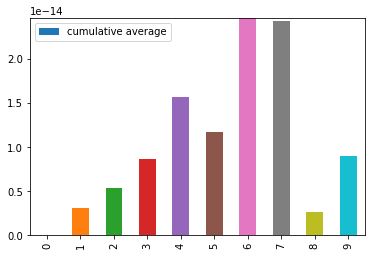

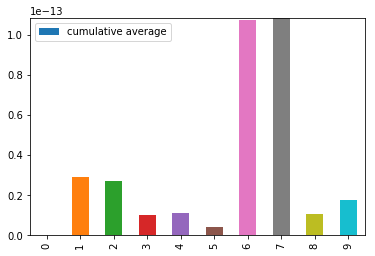

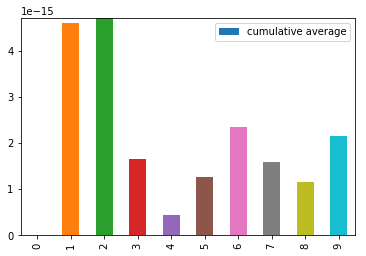

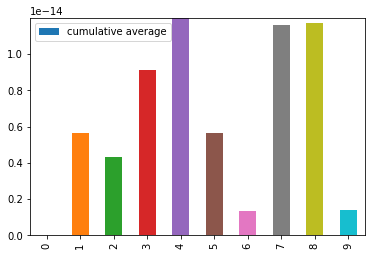

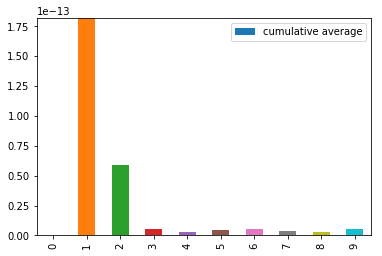

In [11]:
E = np.random.uniform(-1, 1, (N**2))

for i in range(5):
    results = condition(0.70, 1.0e-10, 0, 10)
    results.loc[:, "cumulative average"] = results['diffusion coefficient,cm^2/s'].rolling(2).mean()
    results.plot.bar(y="cumulative average")
plt.show()